In [53]:
# Import necessary libraries
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure imports
sys.path.append(str(Path('..').resolve().parent))
from src.config import FUNK_SVD_MODEL_DIR
from src.recommender import GameRecommender
from src.utils.utils import get_train_data, get_test_data


In [54]:
# Load data and initialize recommender
train_data = get_train_data()
test_data = get_test_data()
model_path = FUNK_SVD_MODEL_DIR / 'model' / 'final'
recommender = GameRecommender(model_path, train_data)


2025-04-13 13:42:28.109 | INFO     | src.funk_svd:load:225 - Loading model from C:\Ukma\coursework\funk-svd\models\funk_svd\model\final


In [55]:
# Core analysis functions
def analyze_user_predictions(user_id):
    """Analyze predictions for a single user without generating recommendations"""
    user_id = int(user_id)

    # Get test items for this user
    user_test_items = [item for item in test_data if int(item['UserId']) == user_id]
    if not user_test_items:
        return pd.DataFrame()

    # Get predictions
    item_ids = [int(item['BggId']) for item in user_test_items]
    predictions = recommender.get_predictions(user_id, item_ids)

    # Process results
    results = []
    for item in user_test_items:
        item_id = int(item['BggId'])
        if item_id in predictions:
            results.append({
                'ItemId': item_id,
                'Actual': float(item['Rating']),
                'Predicted': float(predictions[item_id]),
                'Error': float(item['Rating']) - float(predictions[item_id])
            })

    return pd.DataFrame(results)

def get_user_recommendations(user_id, n_recommendations=10):
    """Get recommendations for a single user"""
    recommendations = recommender.get_top_n_recommendations(user_id, n_recommendations)
    return pd.DataFrame(recommendations, columns=['ItemId', 'PredictedRating'])

def analyze_users(max_users=100):
    """Analyze a sample of users - only predictions, no recommendations"""
    # Get unique user IDs and sample
    test_user_ids = np.unique([int(item['UserId']) for item in test_data])

    # Take a sample if there are more users than max_users
    if len(test_user_ids) > max_users:
        np.random.seed(42)  # For reproducibility
        test_user_ids = np.random.choice(test_user_ids, max_users, replace=False)

    # Collect results
    results = []
    for user_id in test_user_ids:
        predictions_df = analyze_user_predictions(user_id)
        if not predictions_df.empty:
            predictions_df['UserId'] = user_id
            results.append(predictions_df)

    return pd.concat(results) if results else pd.DataFrame()


In [56]:
# Visualization functions
def plot_predictions(df, title):
    """Plot actual vs predicted ratings"""
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Actual'], df['Predicted'], alpha=0.3)
    plt.plot([1, 10], [1, 10], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_error_distribution(df):
    """Plot distribution of prediction errors"""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Error'], bins=20, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Prediction Results:
   ItemId  Actual  Predicted     Error
0  110327     8.5   8.054139  0.445861
1  266507    10.0   9.286861  0.713139
2  198994     7.0   7.877072 -0.877072
3  102652     9.0   7.216909  1.783091
4  175621     6.0   7.001558 -1.001558

Top Recommendations:
   ItemId  PredictedRating
0  255984         9.509138
1  246900         9.409056
2  271320         9.315654
3  266507         9.286861
4  256916         9.281386
5  324856         9.261937
6  291457         9.232955
7  314040         9.140264
8  160069         9.098910
9  251247         9.096005


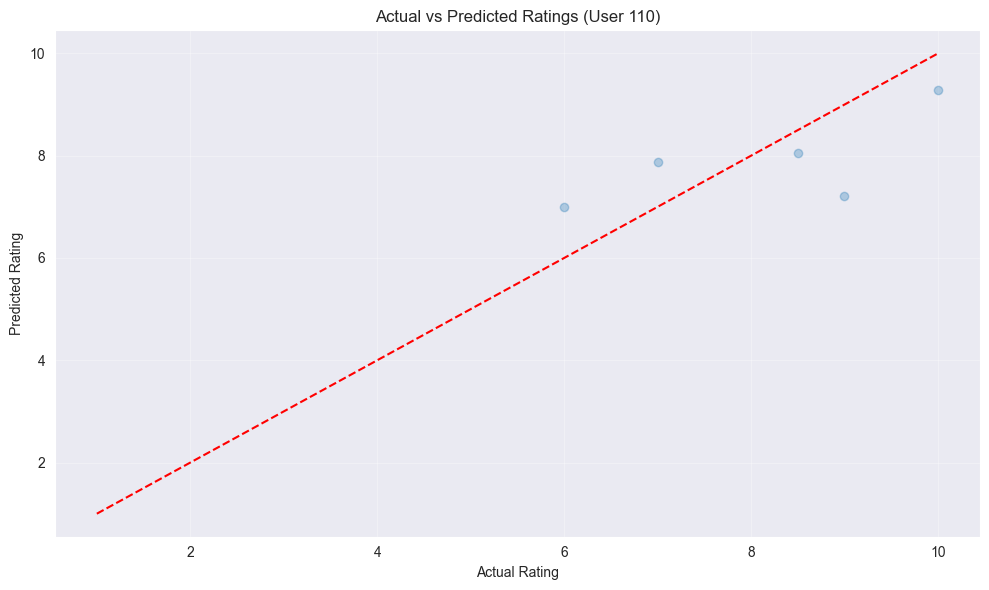

In [57]:
# Analyze a single user
user_id = 110
prediction_df = analyze_user_predictions(user_id)
recommendation_df = get_user_recommendations(user_id)

print("Prediction Results:")
print(prediction_df)
print("\nTop Recommendations:")
print(recommendation_df)

plot_predictions(prediction_df, f'Actual vs Predicted Ratings (User {user_id})')

In [58]:
# Analyze sample of users (100 max)
print("Analyzing sample of users...")
all_predictions_df = analyze_users(max_users=1000)


Analyzing sample of users...


In [59]:
# Calculate performance metrics
rmse = np.sqrt((all_predictions_df['Error'] ** 2).mean())
mae = all_predictions_df['Error'].abs().mean()
corr = np.corrcoef(all_predictions_df['Actual'], all_predictions_df['Predicted'])[0, 1]

print(f"Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")


Performance Metrics:
RMSE: 1.1754
MAE: 0.8892
Correlation: 0.5314


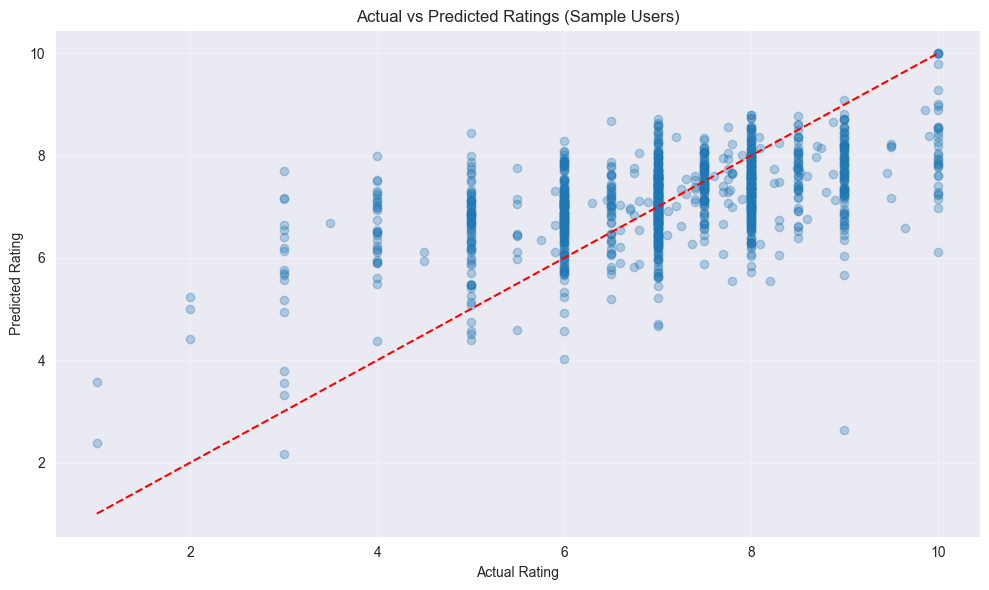

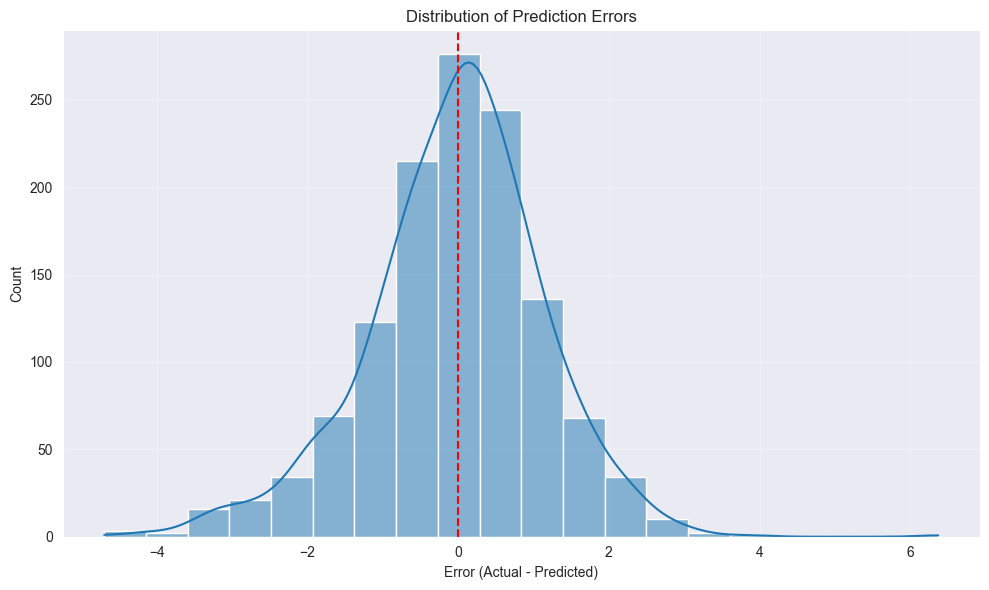

In [60]:
# Visualize overall results
plot_predictions(all_predictions_df, 'Actual vs Predicted Ratings (Sample Users)')
plot_error_distribution(all_predictions_df)


In [61]:
# Compare popular vs personalized recommendations
popular_items = recommender.get_popular_recommendations(train_data, 10)
popular_df = pd.DataFrame(popular_items, columns=['ItemId', 'Score'])

print("Popular Recommendations:")
print(popular_df)

# Compare with a specific user's recommendations
user_id = 110
personal_recs = get_user_recommendations(user_id)
overlap = len(set(personal_recs['ItemId']).intersection(set(popular_df['ItemId'])))

print(f"\nUser {user_id} Recommendations:")
print(personal_recs)
print(f"\nOverlap with popular items: {overlap} items")

Popular Recommendations:
   ItemId      Score
0  167791  45.222855
1   84876  43.452442
2  161936  43.090433
3  169786  42.688970
4   31260  42.093845
5  120677  42.043858
6  173346  41.718424
7  266192  41.583611
8    3076  41.552218
9   68448  41.381946

User 110 Recommendations:
   ItemId  PredictedRating
0  255984         9.509138
1  246900         9.409056
2  271320         9.315654
3  266507         9.286861
4  256916         9.281386
5  324856         9.261937
6  291457         9.232955
7  314040         9.140264
8  160069         9.098910
9  251247         9.096005

Overlap with popular items: 0 items
